<a href="https://colab.research.google.com/github/viniciusbohn/data_science/blob/main/VBB_%5BPTBR%5D_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn Prediction para uma empresa de Telecomunicações**

## Introdução

Considerada uma das principais métricas para qualquer empresa, o *Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Possui extrema importância para a administração do negócio, servindo como referência na detecção de problemas no produto ou na prestação do serviço.

<p align=center>
<img src="https://marketingconteudo.com/wp-content/uploads/2021/01/churn.png" width="60%" height="80%"></p>

A administração do *Churn Rate* pode ser utilizada para identificar potenciais cancelamentos, tornando possível ações preditivas por parte da companhia. De maneira geral sabe-se que o Custo de Aquisição de Cliente (CAC) é normalmente mais elevado do que o custo de retenção de clientes, logo, a empresa que souber prever possíveis cancelamentos e atuar em cima disso tendem a reduzir significativamente seu custo nesse aspecto.

Nesse projeto iremos desenvolver um modelo de Machine Learning para prever potenciais cancelamentos de clientes de uma empresa de telecomunicações. O intuito é criar um modelo com aplicação prática viável, com desempenho bom-razoável.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíveis, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

!pip install scikit-plot -q

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings('ignore')

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


Antes de prosseguirmos para a análise exploratória, vamos segregar nossos dados de teste e removê-los do conjunto principal. Voltaremos a utilizá-los na etapa de teste do modelo.

In [ ]:
print("Original DataFrame Dimensions: ", df.shape)

test = df.sample(frac=0.15, random_state=0)

# Remoção das entradas de teste para utilização do DataFrame de Treino
df = df.drop(test.index)

print("Test DataFrame Dimensions: ", test.shape)
print("Training DataFrame Dimensions: ", df.shape)

Original DataFrame Dimensions:  (7043, 21)
Test DataFrame Dimensions:  (1056, 21)
Training DataFrame Dimensions:  (5987, 21)


## Análise Exploratória dos Dados

Para iniciarmos a análise exploratória, vamos primeiramente verificar o tamanho do DataFrame e suas variáveis. Além disso vamos identificar o tipo de cada uma das variáveis.

In [ ]:
df.shape

(5987, 21)

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Ao avaliarmos as variáveis e seus respectivos tipos, não foi detectada nenhuma variável com necessidade de alteração. Vamos verificar agora a presença de valores nulos ou ausentes no *dataset*.

In [ ]:
nulos = df.isna().sum().sum()
print("The amount of null values in the dataset is:",nulos)

The amount of null values in the dataset is: 0


Note que não há a presença de nenhum valor nulo no nosso DataFrame, podemos prosseguir.

Agora vamos verificar a proporção do nosso *dataset* em relação à variável `Churn`, queremos saber quantas entradas são classificadas como `Churn == Yes` e quantas como `Churn == No`. De forma mais resumida, queremos saber o *Churn Rate* de nosso DataFrame.

In [ ]:
print(df.Churn.value_counts());
print("\n The dataset Churn Rate is {:.2f}%".format(df[df.Churn == 'Yes'].shape[0] / df.shape[0] * 100))

No     4383
Yes    1604
Name: Churn, dtype: int64

 The dataset Churn Rate is 26.79%


Tal proporção também pode ser evidenciada de forma gráfica, conforme abaixo.

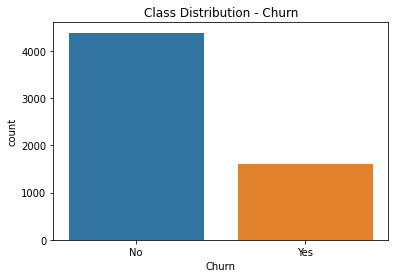

In [ ]:
fig, ax = plt.subplots()
sns.countplot('Churn', data=df, ax=ax)
ax.set_title('Class Distribution - Churn')
plt.plot();

Pudemos identificar a desproporção da variável de classificação, em que temos muito mais entradas para `Churn == No`.

Depois teremos de balancear o conjunto de dados para evitarmos o impacto negativo no nosso modelo.

Vamos verificar o resumo das variáveis numéricas do DataFrame, em busca de possíveis *outliers*.

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5987.000000,5987.000000,5987.000000
mean,0.163354,32.275764,64.880174
std,0.369719,24.568279,29.996011
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.800000
50%,0.000000,29.000000,70.450000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Através do resumo algébrico apresentado não é possível identificar nenhum *outlier* nas variáveis numéricas. Note que as entradas da variável `SeniorCitizen` são apenas `0` ou `1`, devemos interpretá-la como:


*   0 = Não
*   1 = Sim



## Seleção de Atributos Informativos

Nesta seção avaliaremos os atributos de nosso conjunto de dados, visando identificar aqueles que são significativos na classificação de nossa variável alvo, `Churn`. Para esta avaliação utilizaremos os conceitos de entropia (S) e ganho de informação (GI).

Para conseguirmos realizar esta avaliação de uma maneira mais eficaz, vamos iniciar convertendo as entradas da variável `Churn` conforme abaixo:


*   "No" = 0
*   "Yes" = 1



In [ ]:
convert_Churn = {'Yes':1, 'No':0}
df.Churn.replace(convert_Churn, inplace=True)
df.Churn

0       0
1       0
2       1
3       0
4       1
       ..
7036    0
7037    0
7038    0
7040    0
7041    1
Name: Churn, Length: 5987, dtype: int64

Agora que a variável `Churn` está em um formato numérico e binário, podemos calcular o *Churn Rate* para cada segmento formado por uma variável exclusiva. Iniciaremos fazendo a análise completa utilizando a variável `gender` e depois será continuada a análise de forma mais enxuta.

In [ ]:
df[['gender', 'Churn']].groupby(['gender']).mean()

,Churn
gender,
Female,0.273244
Male,0.262596


Note que, quando segmentamos nosso conjunto de dados apenas pelas entradas da variável `gender` (*Female* e *Male*), o *Churn Rate* para cada um dos segmentos apresenta uma diferença pouco significativa em relação ao conjunto pai.



Mas o quê isso representa na nossa seleção dos atributos?

Como mencionado no início da seção, utilizaremos o critério de divisão chamado ganho de informação (GI), baseado na medida de pureza entropia (S), para identificarmos os atributos significativos na segmentação de nossa variável de classificação.

Vamos calcular a entropia dos grupos formado pela divisão através do atributo `gender`:

In [ ]:
S_gender_female = - (((0.273244 * math.log2(0.273244)) + ((1 - 0.273244) * math.log2((1 - 0.273244)))))
S_gender_male = - (((0.262596 * math.log2(0.262596)) + ((1 - 0.262596) * math.log2((1 - 0.262596)))))

print("entropy (gender = 'Female')  = {:.4f}.".format(S_gender_female))
print("entropy (gender = 'Male')  = {:.4f}.".format(S_gender_male))

entropy (gender = 'Female')  = 0.8461.
entropy (gender = 'Male')  = 0.8306.


A entropia de ambos segmentos ficou relativamente alta (1 = completamente impura). Mas mesmo assim ela pode ser significativa para o modelo, desde que calculemos o ganho de informação (GI), relacionando-a à entropia do conjunto pai. Vamos verificar.

In [ ]:
S_parent_node = - ((0.2679 * math.log2(0.2679)) + ((1 - 0.2679) * math.log2((1 - 0.2679))))

print("entropy (parent_node)  = {:.4f}.".format(S_parent_node))

entropy (parent_node)  = 0.8384.


Ao compararmos a entropia do conjunto pai com as calculadas para os segmentos criados pelo atributo `gender`, podemos identificar que os subgrupos formados pela divisão são praticamente equivalentes ao conjunto pai em impureza. Isso significa que não são atributos significativos para nosso modelo de classificação. Vamos evidenciar isso concluindo a análise do ganho de informação.

In [ ]:
df.gender.value_counts()
Pfemale = (df.loc[df['gender'] == 'Female'].shape[0] / df.shape[0])
Pmale = (df.loc[df['gender'] == 'Male'].shape[0] / df.shape[0])

print("Percentage of gender = 'Female' (Pfemale): {:.3f}%.".format(Pfemale))
print("Percentage of gender = 'Male' (Pmale): {:.3f}%.".format(Pmale))

Percentage of gender = 'Female' (Pfemale): 0.499%.
Percentage of gender = 'Male' (Pmale): 0.501%.


In [ ]:
IG_gender = S_parent_node - ((Pfemale * S_gender_female) + (Pmale * S_gender_male))
print("IG (parent_node, gender): {:.6f}.".format(IG_gender))

IG (parent_node, gender): 0.000084.


Ganho de informação ínfimo, podemos concluir que a variável `gender` não é relevante para nossa variável alvo, `Churn`. Logo, não iremos utilizá-la em nosso modelo de classificação.

Agora que fizemos a análise completa do ganho de informação de um atributo, seguiremos a análise dos demais atributos categóricos de forma simplificada, avaliando apenas se há uma diferença significativa no *Churn Rate* ao criarmos diferentes segmentos. Acompanhe abaixo.

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [ ]:
df[['SeniorCitizen', 'Churn']].groupby(['SeniorCitizen']).mean()

,Churn
SeniorCitizen,
0,0.238571
1,0.418200


In [ ]:
df[['Partner', 'Churn']].groupby(['Partner']).mean()

,Churn
Partner,
No,0.331499
Yes,0.200138


In [ ]:
df[['Dependents', 'Churn']].groupby(['Dependents']).mean()

,Churn
Dependents,
No,0.315940
Yes,0.155307


In [ ]:
df[['PhoneService', 'Churn']].groupby(['PhoneService']).mean()

,Churn
PhoneService,
No,0.242321
Yes,0.270691


In [ ]:
df[['MultipleLines', 'Churn']].groupby(['MultipleLines']).mean()

,Churn
MultipleLines,
No,0.252255
No phone service,0.242321
Yes,0.291782


In [ ]:
df[['InternetService', 'Churn']].groupby(['InternetService']).mean()

,Churn
InternetService,
DSL,0.186035
Fiber optic,0.422976
No,0.077882


In [ ]:
df[['OnlineSecurity', 'Churn']].groupby(['OnlineSecurity']).mean()

,Churn
OnlineSecurity,
No,0.419732
No internet service,0.077882
Yes,0.145359


In [ ]:
df[['OnlineBackup', 'Churn']].groupby(['OnlineBackup']).mean()

,Churn
OnlineBackup,
No,0.407491
No internet service,0.077882
Yes,0.207282


In [ ]:
df[['DeviceProtection', 'Churn']].groupby(['DeviceProtection']).mean()

,Churn
DeviceProtection,
No,0.391600
No internet service,0.077882
Yes,0.227670


In [ ]:
df[['TechSupport', 'Churn']].groupby(['TechSupport']).mean()

,Churn
TechSupport,
No,0.417981
No internet service,0.077882
Yes,0.149826


In [ ]:
df[['StreamingTV', 'Churn']].groupby(['StreamingTV']).mean()

,Churn
StreamingTV,
No,0.334308
No internet service,0.077882
Yes,0.304762


In [ ]:
df[['StreamingMovies', 'Churn']].groupby(['StreamingMovies']).mean()

,Churn
StreamingMovies,
No,0.341033
No internet service,0.077882
Yes,0.298019


In [ ]:
df[['Contract', 'Churn']].groupby(['Contract']).mean()

,Churn
Contract,
Month-to-month,0.431592
One year,0.104928
Two year,0.030324


In [ ]:
df[['PaperlessBilling', 'Churn']].groupby(['PaperlessBilling']).mean()

,Churn
PaperlessBilling,
No,0.162039
Yes,0.339396


In [ ]:
df[['PaymentMethod', 'Churn']].groupby(['PaymentMethod']).mean()

,Churn
PaymentMethod,
Bank transfer (automatic),0.164248
Credit card (automatic),0.148499
Electronic check,0.459872
Mailed check,0.193338


Ao avaliarmos os dados acima, podemos destacar atributos bastante significativos e outros nem tanto, como é o caso de `PhoneService` e `MultipleLines`. Vamos remover estas duas colunas, além de `gender`, que vimos anteriormente que também não é significativa, e de `customerID`, que nada agrega para a análise.

In [ ]:
df_clean = df.drop(['PhoneService', 'MultipleLines', 'gender', 'customerID'], axis=1)
df_clean.shape

(5987, 17)

Para finalizarmos a seleção, vamos analisar agora os atributos quantitativos: `tenure`, `MonthlyCharges` e `TotalCharges`.

In [ ]:
df_clean.loc[:, ['tenure', 'MonthlyCharges', 'TotalCharges']][0:5]

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.5
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Note que a variável `TotalCharges` nada mais é que a multiplicação das variáveis `tenure` (número de meses que o cliente está com a companhia) e `MonthlyCharges`(cobrança mensal). Para evitarmos tornar o modelo muito complexo e, assim, mais propenso ao *overfitting*, vamos remover `TotalCharges` do nosso conjunto de dados.

In [ ]:
df_clean = df_clean.drop(['TotalCharges'], axis=1)
df_clean.shape

(5987, 16)

Vamos verificar como está a distruição das variáveis `tenure` e `MonthlyCharges`.

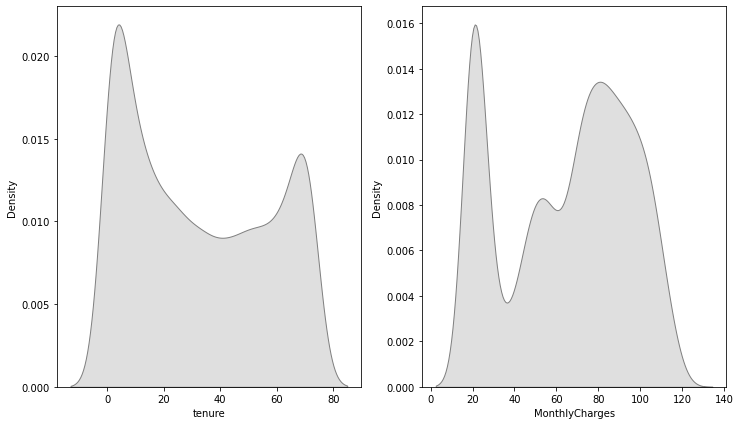

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 7))

sns.kdeplot(df_clean["tenure"], ax=axes[0], color='gray', shade=True);
sns.kdeplot(df_clean["MonthlyCharges"], ax=axes[1], color='gray', shade=True);

Podemos identificar um maior número de entradas nas "condições extremas", gerando um vale nos valores intermediários. Será que esse comportamento se altera quando isolamos casos de *Churn*?

Os dados ilustrados em vermelho são de casos de *Churn*, enquanto os dados em azul são de clientes ativos. Isso vale para ambos os gráficos.

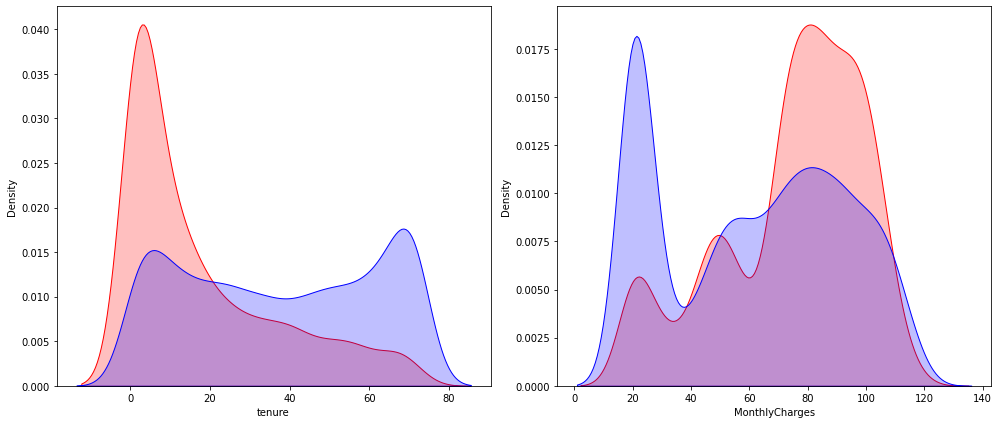

In [ ]:
df_churn_yes = df_clean[df_clean.Churn == 1]
df_churn_no = df_clean[df_clean.Churn == 0]

fig, axes = plt.subplots(1,2, figsize=(14, 6))

sns.kdeplot(df_churn_yes["tenure"], ax=axes[0], color='red', shade=True);
sns.kdeplot(df_churn_no["tenure"], ax=axes[0], color='blue', shade=True);
sns.kdeplot(df_churn_yes["MonthlyCharges"], ax=axes[1], color='red', shade=True);
sns.kdeplot(df_churn_no["MonthlyCharges"], ax=axes[1], color='blue', shade=True);

plt.tight_layout()

Podemos ver claras diferenças em ambos os gráficos. Note que há uma tendência de que clientes há menos tempo com a companhia optem pelo cancelamento, assim como clientes com maiores cobranças mensais. Vamos confirmar estes *insights* com números:

In [ ]:
df_clean[['tenure', 'MonthlyCharges', 'Churn']].groupby('Churn').mean()

,tenure,MonthlyCharges
Churn,,
0,37.635638,61.363587
1,17.629676,74.489401


Conforme esperado, a média de clientes ativos é de aproximadamente 20 meses maior do que de pessoas que optam por sair, assim como as cobranças médias mensais de clientes ativos são significativamente menores do que aqueles que encerraram o vínculo com a companhia.

Isso nos mostra que ambos os atributos são informativos para nosso modelo de previsão de *Churn*, logo, iremos mantê-los no nosso conjunto de dados.

Com isso temos nosso conjunto de dados formado apenas pelos atributos que avaliamos como relevantes para o modelo. Vamos adentrar agora a etapa de preparação dos dados.

## Preparação dos Dados

Vamos iniciar fazendo a preparação dos atributos qualitativos. Para tal, vamos fazer uso do método de Normalização, em que transformaremos tais atributos em entradas numéricas delimitadas na faixa de 0 à 1.

### Normalização dos Atributos Qualitativos

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
atributos_qualitativos = ['SeniorCitizen', 'Partner', 'Dependents','InternetService',
                          'OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport', 'Contract',
                          'StreamingTV','StreamingMovies', 'PaperlessBilling', 'PaymentMethod']

df_norm = pd.get_dummies(df_clean, columns=atributos_qualitativos, drop_first=True)
df_norm.head()

,tenure,MonthlyCharges,Churn,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,2,53.85,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,2,70.70,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Geramos um novo DataFrame (`df_norm`) com os atributos qualitativos normalizados. Note que as colunas originais foram substituídas por variáveis numéricas.

In [ ]:
df_norm.dtypes

tenure                                     int64
MonthlyCharges                           float64
Churn                                      int64
SeniorCitizen_1                            uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
Contract_One year                          uint8
Contract_Two year                          uint8
StreamingTV_No internet service            uint8
StreamingTV_Yes                            uint8
StreamingMovies_No i

### *Feature Scaling* - Variáveis Contínuas

Nesta etapa iremos adequar a escala das variáveis contínuas, de forma com que nosso modelo avalie-as com o mesmo grau de importância.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_norm['tenure'] = MinMaxScaler().fit_transform(df_clean[['tenure']])
df_norm['MonthlyCharges'] = MinMaxScaler().fit_transform(df_clean[['MonthlyCharges']])

df_norm.head()

,tenure,MonthlyCharges,Churn,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.013889,0.115423,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.472222,0.385075,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,0.027778,0.354229,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,0.625000,0.239303,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,0.027778,0.521891,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


### Divisão dos Dados: Treino e Teste

Antes de seguirmos para a etapa de balanceamento dos dados, vamos realizar a divisão do conjunto pai nos conjuntos de treino e teste.

In [ ]:
X = df_norm.drop('Churn', axis=1)
y = df_clean.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.shape

(4490, 25)

In [ ]:
y_train.shape

(4490,)

In [ ]:
X_test.shape

(1497, 25)

In [ ]:
y_test.shape

(1497,)

Agora separamos os dados em quatro novos conjuntos, sendo os DataFrames `X_train` e `Y_train` utilizados para treinamento do modelo e `X_val` e `Y_val` responsáveis pela validação do modelo. Os conjuntos referenciados por "X" (`X_train` e `X_val`) são compostos por todas as variáveis do DataFrame original, exceto `Churn`, enquanto os conjuntos referenciados por "Y" (`Y_train` e `Y_val`) são compostos apenas pelas entradas da variável de classificação, `Churn`. 


### *Cross-validation* Pré-balanceamento

Antes de continuarmos com o balanceamento dos dados, é importante realizarmos a análise de *Cross-validation*. Assim temos uma referência para comparar se os ajustes a seguir irão melhorar ou piorar o desempenho do modelo.

Nessa etapa utilizaremos a Regressão Logística como modelo.

In [ ]:
from sklearn.pipeline import make_pipeline

X = np.array(X)
y = np.array(y)

model = make_pipeline(StandardScaler(), LogisticRegression())
score_baseline = cross_val_score(model, X, y, scoring='recall')

print("Recall: {:.2f} (+/- {:.2f})".format(score_baseline.mean(), score_baseline.std()))

Recall: 0.56 (+/- 0.02)


Certo, já temos uma referência para compararmos com os testes posteriores. Vamos prosseguir com o balanceamento dos dados.

### Balanceamento dos Dados

Conforme mencionado durante a análise exploratória, o conjunto de dados está desbalanceado em relação à nossa variável alvo. Nessa etapa iremos balancear o conjunto para que o nosso *Churn Rate* fique em 50%, sem alterar de maneira significativa a representatividade dos atributos informativos.

In [ ]:
print(y_train.value_counts())

0    3315
1    1175
Name: Churn, dtype: int64


Vamos utilizar o método *Under-sampling*, que consiste em balancear o conjunto de dados preservando a classe minoritária `[Churn == 1]`.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_train = StandardScaler().fit(X_train).transform(X_train)

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [ ]:
print(y_rus.value_counts())

0    1175
1    1175
Name: Churn, dtype: int64


Note que agora temos dois novos conjuntos (`X_rus` e `y_rus`), balanceados em relação à nossa variável alvo.

Com isso concluímos a etapa de preparação dos dados, vamos seguir para o desenvolvimento do modelo de Machine Learning.

## Modelo de Machine Learning

Utilizaremos novamente a técnica de *Cross-validation*, porém dessa vez usando os dados de treino e já balanceados. Aplicaremos a técnica usando os modelos de Regressão Logística e XGBoost, comparando os resultados obtidos de ambos modelos.

In [ ]:
logreg = LogisticRegression()

scores = cross_val_score(logreg, X_rus, y_rus, scoring='recall')

print("Scores: ", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.78297872 0.81276596 0.77446809 0.8212766  0.79574468]
Accuracy: 0.80 (+/- 0.04)


In [ ]:
xgb = XGBClassifier()

scores = cross_val_score(xgb, X_rus, y_rus, scoring='recall')

print("Scores: ", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.82553191 0.85957447 0.80425532 0.83829787 0.80425532]
Accuracy: 0.83 (+/- 0.04)


Ambos os modelos apresentaram resultado muito próximo. Optou-se pela utilização do modelo de XGBoost, pois há uma maior possibilidade de *tuning* de parâmetros para melhorar a qualidade.

## Otimização dos Hiperparâmetros

Vamos otimizar nosso modelo através da técnica *Grid Search*. Nela passamos uma série de valores para determinado parâmetro e ela nos retorna o melhor resultado do modelo e qual o valor utilizado naquele parâmetro para tal.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

parameters = {
        'gamma':[0.001, 0.002, 0.003, 0.004, 0.005]
        }

clf = GridSearchCV(xgb, parameters, scoring='recall')
clf.fit(X_rus, y_rus)

print("Best result: {} using {}".format(clf.best_score_, clf.best_params_))

Best result: 0.8272340425531916 using {'gamma': 0.005}


O método *Grid Search* identificou o melhor valor para o parâmetro `gamma`, para os possíveis valores informados. Vamos "congelar" esse parâmetro em nosso modelo e repetir essa etapa com mais alguns parâmetros.

In [ ]:
xgb = XGBClassifier(learning_rate=0.01, gamma=0.005)

parameters = {
        'n_estimators':[50, 75, 100, 125, 150]
        }

clf = GridSearchCV(xgb, parameters, scoring='recall')
clf.fit(X_rus, y_rus)

print("Best result: {} using {}".format(clf.best_score_, clf.best_params_))

Best result: 0.8382978723404255 using {'n_estimators': 125}


In [ ]:
xgb = XGBClassifier(gamma=0.002, n_estimators=125)

parameters = {
        'learning_rate':[0.001, 0.01, 0.1, 1]
        }

clf = GridSearchCV(xgb, parameters, scoring='recall')
clf.fit(X_rus, y_rus)

print("Best result: {} using {}".format(clf.best_score_, clf.best_params_))

Best result: 0.8417021276595744 using {'learning_rate': 0.001}


Conseguimos obter um ótimo resultado em nosso modelo utilizando a otimização de hiperparâmetros. Agora vamos verificar como o mesmo se comporta quando apresentado aos dados do conjunto de teste.

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      1068
           1       0.46      0.90      0.61       429

    accuracy                           0.67      1497
   macro avg       0.70      0.74      0.66      1497
weighted avg       0.80      0.67      0.69      1497

AUC: 0.7420



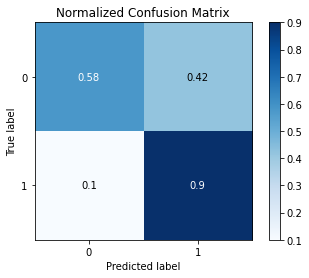

In [ ]:
xgb = XGBClassifier(learning_rate=0.001, gamma=0.005, n_estimators=125)
xgb.fit(X_rus, y_rus)

# fazer a previsão
X_test = StandardScaler().fit(X_test).transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusão

O modelo de Machine Learning se mostrou eficiente na *Churn Prediction*, mesmo quando testado com dados nunca vistos. Obviamente é possível intensificar a otimização dos hiperparâmetros e possivelmente obter resultados ainda mais significativos. Além de outros métodos de balanceamento de dados, *feature scaling* e *feature engineering* que nos permitem uma vasta manipulação dos dados em busca de resultados ainda melhores.

Ainda assim, com um hiperparametrização bastante resumida, o projeto possibilita vermos o impacto positivo que um modelo de Machine Learning gera em um negócio.